Сеть локализует объекты, присутствующие на изображении, и в то же время классифицирует их по различным категориям. Retina использует пирамиду признаков для эффективного обнаружения объектов в нескольких масштабах и вводит Focal Loss, чтобы облегчить проблему экстремального дисбаланса классов переднего плана и фона.
В реализации будет использоваться keras

In [1]:
import os
import re # регулярные выражения
import zipfile # для извлечения датасета
import time # для задержки
from datetime import datetime # для отслеживания времени
from pygame import mixer # плеер

import numpy as np
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import matplotlib.pyplot as plt

os.environ["TF_USE_LEGACY_KERAS"] = "True"

pygame 2.5.2 (SDL 2.28.3, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


Создадим массв, в котором будут хранится распознанные категории

In [3]:
cat = []

In [4]:
def swap_xy(boxes): #меняем x и y местами
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

def convert_to_xywh(boxes): #конвертация в центр и рамку
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

def convert_to_corners(boxes): #конвертация в координаты
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

In [5]:
def compute_iou(boxes1, boxes2):#расчёт iou на основании двух матриц рамок
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

def visualize_detections(image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]):#отображение рамок
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        cat.append(_cls)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [6]:
class AnchorBox: #класс Полей Привязки(ПП)

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0] #пропорции
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]] #масштаб

        self._num_anchors = len(self.aspect_ratios) * len(self.scales) #количество точек привязки
        self._strides = [2 ** i for i in range(3, 8)]  #шаги для карты признаков для FP
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]] #области полей привязки для FP
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):#вычисление размеров ПП
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:#для всех пропорций
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales: #все масштабы
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level): # создание ПП заданного размера для заданного уровня FP
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):# создание ПП для всех уровней
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [7]:
def random_flip_horizontal(image, boxes): # Возможный поворот картинки
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes

def resize_and_pad_image(image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0):#изменение размеров изображения
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

def preprocess_data(sample):#предварительная обработка изображения
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [8]:
class LabelEncoder:#класс меток обучения
    def __init__(self):
        self._anchor_box = AnchorBox()#генерация рамок привязки
        self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)#коэффициенты масштабирования

    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):#Сопоставление полей по IOU
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)#создание матрицы IOU
        max_iou = tf.reduce_max(iou_matrix, axis=1)#максимальное IOU
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)#положительные гипотезы
        negative_mask = tf.less(max_iou, ignore_iou)#отрицательные гипотезы
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))#гипотезы, игнорируемые во время обычения
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):#преобразование подходящих рамок в материал для обучения
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):#создание рамки и классификации для одного примера
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):#создание рамки и классификации для партии изображений
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()


In [9]:
def get_backbone():#создание базы на основе ResNet
    backbone = keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])#подготовка весов
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]

    inputs=backbone.inputs
    outputs=[c3_output, c4_output, c5_output]
    return keras.Model(inputs, outputs)

In [10]:
class FeaturePyramid(keras.layers.Layer):#Создание пирамиды признаков

    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):#создание
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


In [11]:
def build_head(output_filters, bias_init):#классификация
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head


In [12]:
class RetinaNet(keras.Model):
    def __init__(self, num_classes, backbone=None, **kwargs):
        super().__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


In [13]:
class DecodePredictions(tf.keras.layers.Layer):#расшифровка прогнозов
    def __init__(
        self,
        num_classes=80, #количество классов в наборе данных
        confidence_threshold=0.05, #минимальный порог классификации
        nms_iou_threshold=0.5, #пороговое значение IOU для NMS
        max_detections_per_class=100, #максимальное сохранение обнаружений для класса
        max_detections=100, #общее максимальное сохранение обнаружений
        box_variance=[0.1, 0.1, 0.2, 0.2], #коэффициенты масштабирования
        **kwargs
    ):
        super().__init__(**kwargs)#множественное наследование
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


In [14]:
class RetinaNetBoxLoss(tf.losses.Loss):#Реализация плавных потерь
    def __init__(self, delta):
        super().__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetClassificationLoss(tf.losses.Loss):#Реализация Focal Loss
    def __init__(self, alpha, gamma):
        super().__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):#Соединяем обе потери для Retina
    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super().__init__(reduction="none", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss


In [15]:
#параметры тренировки
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 80
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

In [16]:
print(os.environ["TF_USE_LEGACY_KERAS"])

True


In [17]:
#Инициализация модели
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tf_keras\src\initializers\initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [18]:
#Настройка обратного распространения
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

In [31]:
#подгрузка датасета
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [32]:
#Применение алгоритмов
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [21]:
model_dir = "data" 

model.load_weights(latest_checkpoint)# загружаем старые веса

NameError: name 'latest_checkpoint' is not defined

In [22]:
#обучение
model.fit(
    train_dataset.take(100),
    validation_data=val_dataset.take(50),
    epochs=2,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/2



    100/Unknown - 9683s 97s/step - loss: 0.7396
Epoch 1: saving model to retinanet\weights_epoch_1
100/100 [==============================] - 10060s 100s/step - loss: 0.7396 - val_loss: 0.8656
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: 0.7245  
Epoch 2: saving model to retinanet\weights_epoch_2
100/100 [==============================] - 10530s 105s/step - loss: 0.7245 - val_loss: 0.8831


In [22]:
latest_checkpoint = tf.train.latest_checkpoint(model_dir) # сохраняем веса
model.load_weights(latest_checkpoint)

In [23]:
#Создание интерфейса модели
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [33]:
#генерация изображения
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

int2str = dataset_info.features["objects"]["label"].int2str

In [34]:
def gettime():
    now = datetime.now() 
    current_time = now.strftime("_%H_%M_%S")
    return current_time

In [35]:
def getphoto(direct):
    cap = cv2.VideoCapture(0) # включение камеры

    for i in range(30): # "Прогреваем" камеру, чтобы снимок не был тёмным
        cap.read()

    ret, frame = cap.read() # Делаем снимок  

    os.chdir(direct) 
    dirtemp = ('cam' + gettime() + '.jpg')
    cv2.imwrite(dirtemp, frame) # Записываем в файл

    cap.release() # Отключаем камеру
    return dirtemp

Режим мониторинга

In [36]:
d3 = r'C:\Users\ASUS\Desktop\Retina\log'
d2 = r'C:\Users\ASUS\Desktop\Retina\now'
d1 = r'C:\Users\ASUS\Desktop\Retina'

1/1 [==============================] - 6s 6s/step


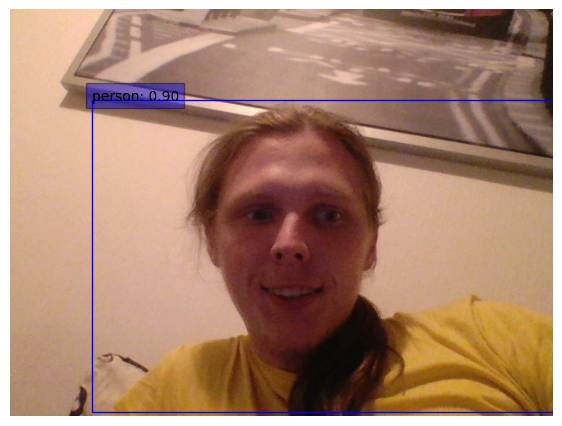

1/1 [==============================] - 6s 6s/step


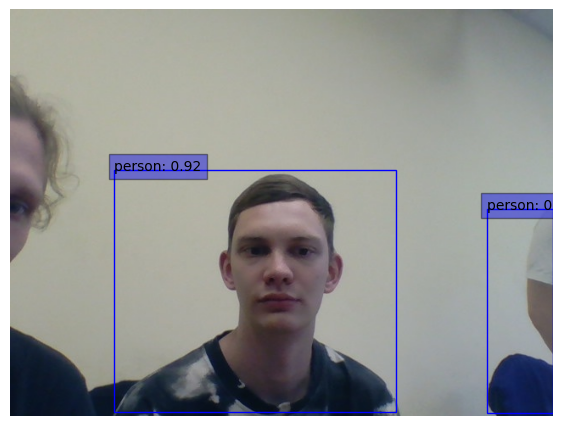

In [ ]:
while True:
    input_arr = []
    dirt=getphoto(d2)
    directory = 'now'
    os.chdir(d1) 
    for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if os.path.isfile(f) and filename.endswith('.jpg'):
        imag = keras.utils.load_img(f)
        input_arr.append(keras.utils.img_to_array(imag))
    
    for temp in input_arr:
      image = tf.cast(temp, dtype=tf.float32)
      input_image, ratio = prepare_image(image)
      detections = inference_model.predict(input_image)
      num_detections = detections.valid_detections[0]
      class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]
      visualize_detections(image, detections.nmsed_boxes[0][:num_detections] / ratio,class_names,detections.nmsed_scores[0][:num_detections],)
    
    if 'person' in cat:
        mixer.init()
        mixer.music.load("msc.mp3")
        mixer.music.play()
        while mixer.music.get_busy():  # ожидание завершения проигрывания
            time.sleep(1)
    
    os.chdir(d2) 
    try:
        os.remove(dirt)
    except: pass
    
    cat=[]
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [ ]:
while True:
    input_arr = []
    dirt=getphoto(d3)
    directory = 'log'
    os.chdir(d1) 
    for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if os.path.isfile(f) and filename.endswith('.jpg'):
        imag = keras.utils.load_img(f)
        input_arr.append(keras.utils.img_to_array(imag))
    
    for temp in input_arr:
      image = tf.cast(temp, dtype=tf.float32)
      input_image, ratio = prepare_image(image)
      start_time = time.time()


      detections = inference_model.predict(input_image)
      end_time = time.time()
      print(end_time - start_time)
      num_detections = detections.valid_detections[0]
      class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]
      visualize_detections(image, detections.nmsed_boxes[0][:num_detections] / ratio,class_names,detections.nmsed_scores[0][:num_detections],)
    
    if 'person' in cat:
        os.replace(os.path.join(d3, dirt), os.path.join(d3, 'persons', dirt))

    elif ('cat' in cat) or ('dog' in cat) or ('bear' in cat):
        os.replace(os.path.join(d3, dirt), os.path.join(d3, 'animals', dirt))
    
    else:
        os.chdir(d3) 
        try:
            os.remove(dirt)
        except: pass
            
    os.sleep(10)
    cat=[]
    if cv2.waitKey(1) & 0xFF == ord('w'):
        break